# FOMO - Faster Objects, More Objects

### Import modules

In [1]:
import pytorch_lightning as pl
import torch

from pathlib import Path
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image
from torchvision.transforms import Resize

### Constants

In [2]:
DATASET_DIR = Path('vehicle_detection_dataset')
IMAGE_RESOLUTION = int(1280 / 4)  # model input image resolution
GRID_SCALE = 8  # number of pixels per cell on grid (vertically and horizontally)
GRID_RESOLUTION = int(IMAGE_RESOLUTION / GRID_SCALE)

### Dataset

In [3]:
class VehicleDataset(Dataset):
    def __init__(self, dataset_dir: Path, subset: list[str], transform=None, target_transform=None):
        self._images = [dataset_dir / 'images' / (element + ".jpg") for element in subset]
        self._bounding_boxes = [dataset_dir / 'bounding_boxes' / (element + ".txt") for element in subset]
        self._transform = transform
        self._target_transform = target_transform
    
    def __getitem__(self, idx: int):
        image_file = self._images[idx]
        image = read_image(str(image_file))
        image = self._transform(image)

        bounding_box_file = self._bounding_boxes[idx]
        mask = torch.zeros((GRID_RESOLUTION, GRID_RESOLUTION), dtype=int)  # 0 in that mask stands for background, next values represent corresponding classes
        # TODO move code below to custom class, so it works the same way as Resize() does
        with open(bounding_box_file) as bb_file:
            bounding_boxes = bb_file.readlines()
            for bounding_box in bounding_boxes:
                [c, x, y, w, h] = [float(coords) for coords in bounding_box.split()]  # get bounding box class, position and dimension
                xp = int((x + (w / 2)) * IMAGE_RESOLUTION)  # calculate center of bounding box
                yp = int((y + (h / 2)) * IMAGE_RESOLUTION)
                xp_idx = int(xp / GRID_SCALE)  # calculate cell coordinates, with center of bounding box 
                yp_idx = int(yp / GRID_SCALE)
                mask[yp_idx, xp_idx] = c + 1  # mark cell containing center of bounding box, with class value increased by 1

        return image, mask

    def __len__(self):
        return len(self._images)

### DataModule

In [4]:
class VehicleDataModule(pl.LightningDataModule):
    def __init__(self, dataset_dir: Path, batch_size: int = 32):
        super().__init__()
        self._dataset_dir = dataset_dir
        self._batch_size = batch_size
        self._transform = Resize((IMAGE_RESOLUTION, IMAGE_RESOLUTION))  # where should IMAGE_RESOLUTION and GRID_SCALE be defined, so they won't be a global variable?
        self._train_dataset = None
        self._val_dataset = None

    def setup(self, stage: str):
        data_names = sorted([data_name for data_name in (self._dataset_dir / 'images').iterdir()])
        train_names, val_names = random_split(data_names, [0.85, 0.15])
        self._train_dataset = VehicleDataset(self._dataset_dir, [data_names[idx].stem for idx in train_names.indices], self._transform)
        self._val_dataset = VehicleDataset(self._dataset_dir, [data_names[idx].stem for idx in val_names.indices], self._transform)
        
    def train_dataloader(self):
        return DataLoader(self._train_dataset, batch_size=self._batch_size)

    def val_dataloader(self):
        return DataLoader(self._val_dataset, batch_size=self._batch_size)

TESTS

In [5]:
vehicle_data_module = VehicleDataModule(dataset_dir=DATASET_DIR)
vehicle_data_module.setup(stage=None)
train_loader = vehicle_data_module.train_dataloader()
data = next(iter(train_loader))

/home/krzy5z70f/Documents/Term_7/FOMO/.fomo_venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


There are 13 objects in the picture


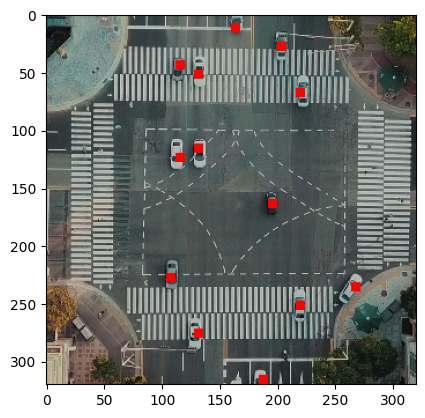

In [6]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

data_idx = 0
image = data[0][data_idx]
mask = data[1][data_idx]

image = image.permute(1, 2, 0).numpy()
mask = mask.numpy()

mask_res = cv2.resize(mask, dsize=(IMAGE_RESOLUTION, IMAGE_RESOLUTION), interpolation=cv2.INTER_NEAREST)
image[mask_res == 1] = [255, 0, 0]
plt.imshow(image)

cnt = np.count_nonzero(mask == 1)
print("There are", str(cnt), "objects in the picture")